# Introduction
This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc
  * what is the importance/meaning of solving the problem
  * what is the difficulty of the problem
  * the state of the art methods and effectiveness.
*   Paper explanation
  * what did the paper propose
  * what is the innovations of the method
  * how well the proposed method work (in its own metrics)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).


In [ ]:
# code comment is used as inline annotations for your coding

# Scope of Reproducibility:

Hypothesis 1: Including the time between visits will improve the model over the base model that treats all visits in a simple sequential manner.

Hypothesis 2: Including domain knowledge, along with the time between visits, will lead to a better performing model than the base model.


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [ ]:
# import  packages you need
import numpy as np
from google.colab import drive


##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.
  * Illustration: printing results, plotting figures for illustration.
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.

In [1]:
from pyhealth.datasets import MIMIC3Dataset
from pyhealth.datasets import split_by_patient, get_dataloader
from pyhealth.models import RNN
from pyhealth.trainer import Trainer

C:\Users\John\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
base_dataset = MIMIC3Dataset(
    root="https://storage.googleapis.com/pyhealth/Synthetic_MIMIC-III/",
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD"],
    code_mapping={"ICD9CM": "CCSCM", "ICD9PROC": "CCSPROC"},
    dev=False,
    refresh_cache=False,
)
base_dataset.stat()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
finish basic patient information parsing : 24.554774284362793s
finish parsing DIAGNOSES_ICD : 23.138164520263672s
finish parsing PROCEDURES_ICD : 14.91417407989502s


Mapping codes: 100%|███████████████████████████████████████████████████████████| 49993/49993 [00:14<00:00, 3515.23it/s]



Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 49993
	- Number of visits: 52769
	- Number of visits per patient: 1.0555
	- Number of events per visit in DIAGNOSES_ICD: 9.1038
	- Number of events per visit in PROCEDURES_ICD: 3.2186



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 49993\n\t- Number of visits: 52769\n\t- Number of visits per patient: 1.0555\n\t- Number of events per visit in DIAGNOSES_ICD: 9.1038\n\t- Number of events per visit in PROCEDURES_ICD: 3.2186\n'

In [15]:
from pyhealth.medcode import CrossMap
from pyhealth.medcode import InnerMap

mapping = CrossMap.load(source_vocabulary="ICD9CM", target_vocabulary="CCSCM")
print("The CCSCM code that maps to ICD-9 code 428.9 (conjestive heart failure) is", mapping.map("428.9"))

ccscm = InnerMap.load("CCSCM")
print("Confirmation that CCSCM code '108' corresponds to", ccscm.lookup("108"))

The CCSCM code that maps to ICD-9 code 428.9 (conjestive heart failure) is ['108']
Confirmation that CCSCM code '108' corresponds to Congestive heart failure; nonhypertensive


In [16]:
# Create custom visit time difference calculation and heart failure prediction task
from pyhealth.data import Patient, Visit
import numpy as np


def visit_time_diff_mimic3_fn(patient: Patient):
    """Processes a single patient for the visit time difference task.

    Visit time difference calculates the delay between the current visit and
    the previous visit.

    Args:
        patient: a Patient object

    Returns:
        samples: a list of samples, each sample is a dict with patient_id,
            visit_id, and other task-specific attributes as key

    Examples:
        >>> from pyhealth.datasets import MIMIC3Dataset
        >>> mimic3_base = MIMIC3Dataset(
        ...    root="/srv/local/data/physionet.org/files/mimiciii/1.4",
        ...    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],
        ...    code_mapping={"ICD9CM": "CCSCM"},
        ... )
        >>> from pyhealth.tasks import hf_prediction_mimic3_fn
        >>> mimic3_sample = mimic3_base.set_task(visit_time_diff_mimic3_fn)
        >>> mimic3_sample.samples[0]
        [{'visit_id': '130744', 'patient_id': '103', 'conditions': [['42', '109', '19', '122', '98', '663', '58', '51']], 'procedures': [['1']], 'visit_diff': [[0.0, 0.0, 0.0, 0.0]] 'label': 0}]
    """
    samples = []
    criterion_time = None
        
    for i in range(len(patient) - 1):
        visit: Visit = patient[i]
        visit_time = visit.encounter_time

        next_visit: Visit = patient[i + 1]
        hf_label = 0

        if '108' not in next_visit.get_code_list(table="DIAGNOSES_ICD"):
            hf_label = 0
        else:
            hf_label = 1
    
        visit_diff = []

        if i > 0:
            prev_visit: Visit = patient[i - 1]
            prev_visit_time = prev_visit.encounter_time

            # Find criterion time (i.e. first encounter with HF diagnosis)
            for j in range(len(patient) - 1):
                c_visit: Visit = patient[j]
                if criterion_time == None and '108' in c_visit.get_code_list(table="DIAGNOSES_ICD"):
                    criterion_time = c_visit.encounter_time

            if criterion_time != None:
                v_c_s = np.sin(((visit_time - criterion_time).days)/10000).item()
                v_c_c = np.cos(((visit_time - criterion_time).days)/10000).item()
            else:
                v_c = 0.0
                v_c_s = 0.0
                v_c_c = 0.0
                
            v_p = visit_time - prev_visit_time
            
            visit_diff = [
                v_c_s,
                v_c_c,
                np.sin(((v_p).days)/10000).item(),
                np.cos(((v_p).days)/10000).item()
            ]

        else:
            visit_diff = [0.0, 0.0, 0.0, 0.0]

        conditions = visit.get_code_list(table="DIAGNOSES_ICD")
        procedures = visit.get_code_list(table="PROCEDURES_ICD")
        # exclude: visits without condition and procedure code
        if len(conditions) * len(procedures) == 0 or len(patient) < 2:
            continue
        samples.append(
            {
                "visit_id": visit.visit_id,
                "patient_id": patient.patient_id,
                "conditions": [conditions],
                "procedures": [procedures],
                "visit_diff": [visit_diff],
                "label": hf_label,
            }
        )
    # no cohort selection
    return samples

In [24]:
sample_dataset = base_dataset.set_task(visit_time_diff_mimic3_fn)
sample_dataset.stat()
print(sample_dataset[9]) #9

train_dataset, val_dataset, test_dataset = split_by_patient(
    sample_dataset, [0.8, 0.1, 0.1]
)

train_dataloader = get_dataloader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=32, shuffle=False)

Generating samples for visit_time_diff_mimic3_fn: 100%|██████████████████████| 49993/49993 [00:00<00:00, 434171.73it/s]

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: visit_time_diff_mimic3_fn
	- Number of samples: 2218
	- Number of patients: 2129
	- Number of visits: 2218
	- Number of visits per patient: 1.0418
	- conditions:
		- Number of conditions per sample: 9.6145
		- Number of unique conditions: 255
		- Distribution of conditions (Top-10): [('98', 890), ('101', 844), ('106', 712), ('238', 636), ('108', 587), ('55', 559), ('53', 536), ('49', 506), ('259', 411), ('59', 382)]
	- procedures:
		- Number of procedures per sample: 3.6510
		- Number of unique procedures: 172
		- Distribution of procedures (Top-10): [('54', 548), ('47', 531), ('216', 488), ('222', 484), ('50', 436), ('61', 344), ('44', 327), ('223', 268), ('231', 219), ('193', 209)]
	- visit_diff:
		- Number of visit_diff per sample: 1.0000
		- Length of visit_diff: 4
	- label:
		- Number of label per sample: 1.0000
		- Number of unique label: 2
		- Distribution of label (Top-10): [(0, 1760), (1, 458)]
{'visit_id': '1105

In [16]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the CSV data into a pandas DataFrame
file = 'kg_grouped_diseases_bert_map.csv' 
df = pd.read_csv(file)

# Display the first few rows of the DataFrame to understand its structure
df.head()


,node_id,node_type,node_name,node_source,group_name_auto,group_name_bert,group_id_bert
0,13924,disease,osteogenesis imperfecta type 13,MONDO,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...
1,12592,disease,osteogenesis imperfecta type 11,MONDO,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...
2,14672,disease,osteogenesis imperfecta type 17,MONDO,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...
3,13460,disease,osteogenesis imperfecta type 12,MONDO,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...
4,12591,disease,osteogenesis imperfecta type 5,MONDO,osteogenesis imperfecta,osteogenesis imperfecta,13924_12592_14672_13460_12591_12536_30861_8146...


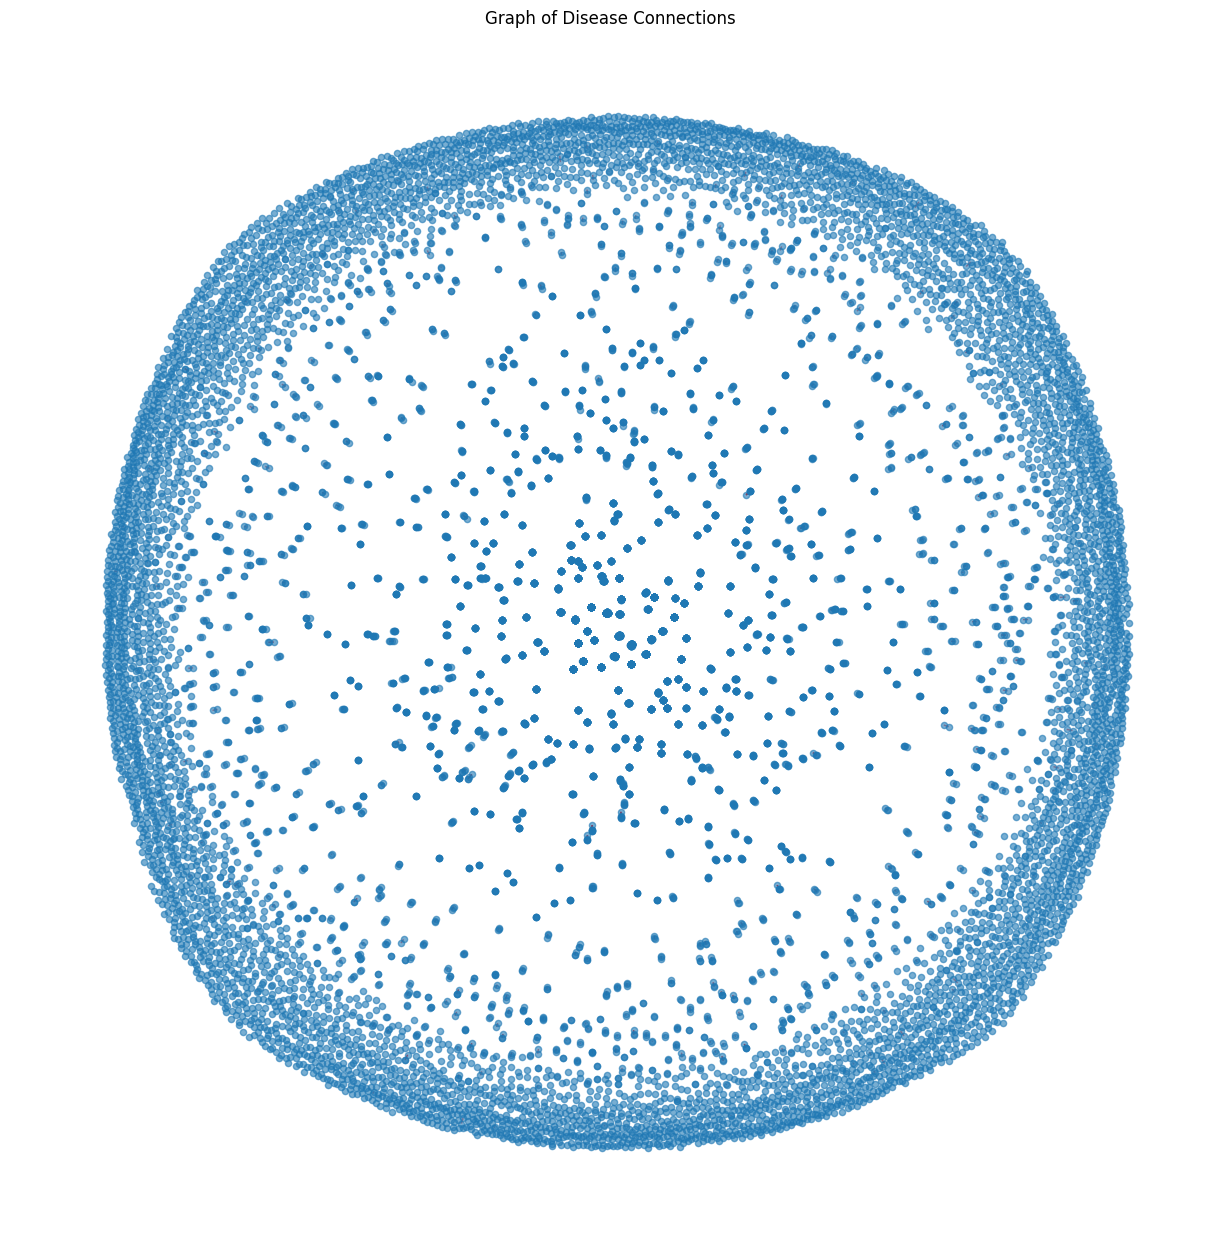

In [17]:
# Function to extract unique edges from the group_id_bert column
def extract_edges(grouped_ids):
    # Split the string by underscore and convert to set for unique ids
    ids = set(grouped_ids.split('_'))
    # Create a list of tuples representing edges (all possible combinations without repetition)
    edges = [(a, b) for idx, a in enumerate(ids) for b in list(ids)[idx + 1:]]
    return edges

# Initialize an empty graph
G = nx.Graph()

# Add nodes and edges to the graph
for _, row in df.iterrows():
    # Add the disease node to the graph
    G.add_node(row['node_id'], name=row['node_name'], type=row['node_type'], source=row['node_source'])
    
    # Add edges from this disease to others in the same group
    edges = extract_edges(row['group_id_bert'])
    G.add_edges_from(edges)

# Now, let's visualize the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20, alpha=0.6, edge_color="r", font_size=8)
plt.title("Graph of Disease Connections")
plt.show()

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

In [18]:
base_model = RNN(
    dataset=sample_dataset,
    feature_keys=["conditions", "procedures"],
    label_key="label",
    mode="binary",
)

In [19]:
base_trainer = Trainer(model=base_model)
base_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=50,
    monitor="roc_auc",
)

RNN(
  (embeddings): ModuleDict(
    (conditions): Embedding(257, 128, padding_idx=0)
    (procedures): Embedding(174, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (rnn): ModuleDict(
    (conditions): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
    (procedures): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
  )
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Metrics: None
Device: cpu

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001C66F820DD0>
Monitor: roc_auc
Monitor criterion: max
Epochs: 50



Epoch 0 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-0, step-56 ---
loss: 0.5465


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 259.24it/s]

--- Eval epoch-0, step-56 ---
pr_auc: 0.2403
roc_auc: 0.4580
f1: 0.0000
loss: 0.5886
New best roc_auc score (0.4580) at epoch-0, step-56



Epoch 1 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-1, step-112 ---
loss: 0.5019


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 327.95it/s]

--- Eval epoch-1, step-112 ---
pr_auc: 0.2460
roc_auc: 0.5012
f1: 0.0000
loss: 0.5743
New best roc_auc score (0.5012) at epoch-1, step-112



Epoch 2 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-2, step-168 ---
loss: 0.4899


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 263.88it/s]

--- Eval epoch-2, step-168 ---
pr_auc: 0.2737
roc_auc: 0.5315
f1: 0.0000
loss: 0.5698
New best roc_auc score (0.5315) at epoch-2, step-168



Epoch 3 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-3, step-224 ---
loss: 0.4777


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 267.19it/s]

--- Eval epoch-3, step-224 ---
pr_auc: 0.2860
roc_auc: 0.5347
f1: 0.0364
loss: 0.5820
New best roc_auc score (0.5347) at epoch-3, step-224



Epoch 4 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-4, step-280 ---
loss: 0.4608


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 278.15it/s]

--- Eval epoch-4, step-280 ---
pr_auc: 0.3015
roc_auc: 0.5640
f1: 0.1000
loss: 0.5685
New best roc_auc score (0.5640) at epoch-4, step-280



Epoch 5 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-5, step-336 ---
loss: 0.4462


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 311.90it/s]

--- Eval epoch-5, step-336 ---
pr_auc: 0.3062
roc_auc: 0.5683
f1: 0.1000
loss: 0.5791
New best roc_auc score (0.5683) at epoch-5, step-336



Epoch 6 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-6, step-392 ---
loss: 0.4400


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 297.56it/s]

--- Eval epoch-6, step-392 ---
pr_auc: 0.3014
roc_auc: 0.5734
f1: 0.1250
loss: 0.5803
New best roc_auc score (0.5734) at epoch-6, step-392



Epoch 7 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-7, step-448 ---
loss: 0.4275


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 275.28it/s]

--- Eval epoch-7, step-448 ---
pr_auc: 0.3130
roc_auc: 0.5703
f1: 0.1493
loss: 0.5857



Epoch 8 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-8, step-504 ---
loss: 0.4095


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 289.51it/s]

--- Eval epoch-8, step-504 ---
pr_auc: 0.3151
roc_auc: 0.5779
f1: 0.0923
loss: 0.5947
New best roc_auc score (0.5779) at epoch-8, step-504



Epoch 9 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-9, step-560 ---
loss: 0.4043


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 259.59it/s]

--- Eval epoch-9, step-560 ---
pr_auc: 0.3114
roc_auc: 0.5611
f1: 0.1429
loss: 0.6004



Epoch 10 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-10, step-616 ---
loss: 0.3823


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.69it/s]

--- Eval epoch-10, step-616 ---
pr_auc: 0.3026
roc_auc: 0.5479
f1: 0.1290
loss: 0.6355



Epoch 11 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-11, step-672 ---
loss: 0.3811


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 295.54it/s]

--- Eval epoch-11, step-672 ---
pr_auc: 0.2981
roc_auc: 0.5595
f1: 0.1471
loss: 0.6309



Epoch 12 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-12, step-728 ---
loss: 0.3583


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.27it/s]

--- Eval epoch-12, step-728 ---
pr_auc: 0.2999
roc_auc: 0.5624
f1: 0.1515
loss: 0.6416



Epoch 13 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-13, step-784 ---
loss: 0.3441


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 297.65it/s]

--- Eval epoch-13, step-784 ---
pr_auc: 0.2863
roc_auc: 0.5386
f1: 0.1690
loss: 0.6713



Epoch 14 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-14, step-840 ---
loss: 0.3298


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 311.53it/s]

--- Eval epoch-14, step-840 ---
pr_auc: 0.3072
roc_auc: 0.5467
f1: 0.1644
loss: 0.6710



Epoch 15 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-15, step-896 ---
loss: 0.3205


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 322.68it/s]

--- Eval epoch-15, step-896 ---
pr_auc: 0.2843
roc_auc: 0.5397
f1: 0.1690
loss: 0.6909



Epoch 16 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-16, step-952 ---
loss: 0.3149


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 277.98it/s]

--- Eval epoch-16, step-952 ---
pr_auc: 0.3142
roc_auc: 0.5635
f1: 0.1867
loss: 0.6698



Epoch 17 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-17, step-1008 ---
loss: 0.3088


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.67it/s]

--- Eval epoch-17, step-1008 ---
pr_auc: 0.3039
roc_auc: 0.5619
f1: 0.1772
loss: 0.6886



Epoch 18 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-18, step-1064 ---
loss: 0.2764


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 279.93it/s]

--- Eval epoch-18, step-1064 ---
pr_auc: 0.2818
roc_auc: 0.5493
f1: 0.1558
loss: 0.7168



Epoch 19 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-19, step-1120 ---
loss: 0.2694


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 286.87it/s]

--- Eval epoch-19, step-1120 ---
pr_auc: 0.2995
roc_auc: 0.5439
f1: 0.1579
loss: 0.7336



Epoch 20 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-20, step-1176 ---
loss: 0.2659


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 267.68it/s]

--- Eval epoch-20, step-1176 ---
pr_auc: 0.2997
roc_auc: 0.5500
f1: 0.1500
loss: 0.7410



Epoch 21 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-21, step-1232 ---
loss: 0.2705


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 275.58it/s]

--- Eval epoch-21, step-1232 ---
pr_auc: 0.2937
roc_auc: 0.5553
f1: 0.1728
loss: 0.7322



Epoch 22 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-22, step-1288 ---
loss: 0.2581


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 325.67it/s]

--- Eval epoch-22, step-1288 ---
pr_auc: 0.2684
roc_auc: 0.5377
f1: 0.0845
loss: 0.7802



Epoch 23 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-23, step-1344 ---
loss: 0.2365


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 269.25it/s]

--- Eval epoch-23, step-1344 ---
pr_auc: 0.2616
roc_auc: 0.5377
f1: 0.0857
loss: 0.7891



Epoch 24 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-24, step-1400 ---
loss: 0.2228


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 275.94it/s]

--- Eval epoch-24, step-1400 ---
pr_auc: 0.2594
roc_auc: 0.5342
f1: 0.0571
loss: 0.8123



Epoch 25 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-25, step-1456 ---
loss: 0.2269


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.71it/s]

--- Eval epoch-25, step-1456 ---
pr_auc: 0.2655
roc_auc: 0.5485
f1: 0.1951
loss: 0.7963



Epoch 26 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-26, step-1512 ---
loss: 0.2141


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 330.58it/s]

--- Eval epoch-26, step-1512 ---
pr_auc: 0.2536
roc_auc: 0.5400
f1: 0.1266
loss: 0.8158



Epoch 27 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-27, step-1568 ---
loss: 0.2226


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 274.33it/s]

--- Eval epoch-27, step-1568 ---
pr_auc: 0.2526
roc_auc: 0.5327
f1: 0.0845
loss: 0.8421



Epoch 28 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-28, step-1624 ---
loss: 0.2177


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 301.90it/s]

--- Eval epoch-28, step-1624 ---
pr_auc: 0.2550
roc_auc: 0.5357
f1: 0.1299
loss: 0.8351



Epoch 29 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-29, step-1680 ---
loss: 0.1967


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 271.69it/s]

--- Eval epoch-29, step-1680 ---
pr_auc: 0.2554
roc_auc: 0.5305
f1: 0.1127
loss: 0.8803



Epoch 30 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-30, step-1736 ---
loss: 0.1987


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 342.67it/s]

--- Eval epoch-30, step-1736 ---
pr_auc: 0.2535
roc_auc: 0.5340
f1: 0.1707
loss: 0.8599



Epoch 31 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-31, step-1792 ---
loss: 0.1773


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 320.94it/s]

--- Eval epoch-31, step-1792 ---
pr_auc: 0.2605
roc_auc: 0.5392
f1: 0.1905
loss: 0.8693



Epoch 32 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-32, step-1848 ---
loss: 0.1891


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 267.19it/s]

--- Eval epoch-32, step-1848 ---
pr_auc: 0.2523
roc_auc: 0.5268
f1: 0.0882
loss: 0.9467



Epoch 33 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-33, step-1904 ---
loss: 0.1840


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.29it/s]

--- Eval epoch-33, step-1904 ---
pr_auc: 0.2556
roc_auc: 0.5250
f1: 0.1951
loss: 0.8929



Epoch 34 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-34, step-1960 ---
loss: 0.1671


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 280.00it/s]

--- Eval epoch-34, step-1960 ---
pr_auc: 0.2444
roc_auc: 0.5084
f1: 0.0822
loss: 0.9465



Epoch 35 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-35, step-2016 ---
loss: 0.1783


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 349.99it/s]

--- Eval epoch-35, step-2016 ---
pr_auc: 0.2397
roc_auc: 0.5057
f1: 0.1039
loss: 0.9554



Epoch 36 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-36, step-2072 ---
loss: 0.1572


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 290.01it/s]

--- Eval epoch-36, step-2072 ---
pr_auc: 0.2327
roc_auc: 0.4927
f1: 0.1538
loss: 1.0025



Epoch 37 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-37, step-2128 ---
loss: 0.1448


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 291.69it/s]

--- Eval epoch-37, step-2128 ---
pr_auc: 0.2318
roc_auc: 0.4896
f1: 0.0811
loss: 1.0508



Epoch 38 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-38, step-2184 ---
loss: 0.1610


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 186.51it/s]

--- Eval epoch-38, step-2184 ---
pr_auc: 0.2284
roc_auc: 0.4917
f1: 0.1235
loss: 1.0174



Epoch 39 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-39, step-2240 ---
loss: 0.1419


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 279.96it/s]

--- Eval epoch-39, step-2240 ---
pr_auc: 0.2368
roc_auc: 0.5026
f1: 0.1250
loss: 1.0564



Epoch 40 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-40, step-2296 ---
loss: 0.1561


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 312.10it/s]

--- Eval epoch-40, step-2296 ---
pr_auc: 0.2360
roc_auc: 0.4992
f1: 0.0822
loss: 1.0656



Epoch 41 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-41, step-2352 ---
loss: 0.1417


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 269.16it/s]

--- Eval epoch-41, step-2352 ---
pr_auc: 0.2396
roc_auc: 0.5065
f1: 0.1081
loss: 1.0260



Epoch 42 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-42, step-2408 ---
loss: 0.1446


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 269.25it/s]

--- Eval epoch-42, step-2408 ---
pr_auc: 0.2478
roc_auc: 0.5268
f1: 0.1081
loss: 1.0271



Epoch 43 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-43, step-2464 ---
loss: 0.1342


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 297.66it/s]

--- Eval epoch-43, step-2464 ---
pr_auc: 0.2481
roc_auc: 0.5287
f1: 0.1205
loss: 1.0018



Epoch 44 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-44, step-2520 ---
loss: 0.1428


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 302.32it/s]

--- Eval epoch-44, step-2520 ---
pr_auc: 0.2575
roc_auc: 0.5429
f1: 0.1250
loss: 1.0233



Epoch 45 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-45, step-2576 ---
loss: 0.1314


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 321.84it/s]

--- Eval epoch-45, step-2576 ---
pr_auc: 0.2552
roc_auc: 0.5427
f1: 0.1250
loss: 1.0230



Epoch 46 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-46, step-2632 ---
loss: 0.1267


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 259.26it/s]

--- Eval epoch-46, step-2632 ---
pr_auc: 0.2440
roc_auc: 0.5220
f1: 0.0800
loss: 1.0743



Epoch 47 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-47, step-2688 ---
loss: 0.1182


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 237.42it/s]

--- Eval epoch-47, step-2688 ---
pr_auc: 0.2487
roc_auc: 0.5322
f1: 0.1039
loss: 1.0973



Epoch 48 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-48, step-2744 ---
loss: 0.1326


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 278.51it/s]

--- Eval epoch-48, step-2744 ---
pr_auc: 0.2412
roc_auc: 0.5261
f1: 0.0800
loss: 1.0898



Epoch 49 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-49, step-2800 ---
loss: 0.1301


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 289.46it/s]

--- Eval epoch-49, step-2800 ---
pr_auc: 0.2364
roc_auc: 0.5147
f1: 0.1235
loss: 1.0749
Loaded best model


In [20]:
time_model = RNN(
    dataset=sample_dataset,
    feature_keys=["conditions", "procedures", "visit_diff"],
    label_key="label",
    mode="binary",
)

In [21]:
time_trainer = Trainer(model=time_model)
time_trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=50,
    monitor="roc_auc",
)

RNN(
  (embeddings): ModuleDict(
    (conditions): Embedding(257, 128, padding_idx=0)
    (procedures): Embedding(174, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict(
    (visit_diff): Linear(in_features=4, out_features=128, bias=True)
  )
  (rnn): ModuleDict(
    (conditions): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
    (procedures): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
    (visit_diff): RNNLayer(
      (dropout_layer): Dropout(p=0.5, inplace=False)
      (rnn): GRU(128, 128, batch_first=True)
    )
  )
  (fc): Linear(in_features=384, out_features=1, bias=True)
)
Metrics: None
Device: cpu

Training:
Batch size: 32
Optimizer: <class 'torch.optim.adam.Adam'>
Optimizer params: {'lr': 0.001}
Weight decay: 0.0
Max grad norm: None
Val dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001C66F820DD0>
Monitor: roc_auc
Mon

Epoch 0 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-0, step-56 ---
loss: 0.5361


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 245.42it/s]

--- Eval epoch-0, step-56 ---
pr_auc: 0.2587
roc_auc: 0.4972
f1: 0.0000
loss: 0.5830
New best roc_auc score (0.4972) at epoch-0, step-56



Epoch 1 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-1, step-112 ---
loss: 0.4966


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 203.48it/s]

--- Eval epoch-1, step-112 ---
pr_auc: 0.3189
roc_auc: 0.5522
f1: 0.0000
loss: 0.5592
New best roc_auc score (0.5522) at epoch-1, step-112



Epoch 2 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-2, step-168 ---
loss: 0.4813


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 196.81it/s]

--- Eval epoch-2, step-168 ---
pr_auc: 0.2866
roc_auc: 0.5391
f1: 0.0000
loss: 0.5702



Epoch 3 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-3, step-224 ---
loss: 0.4765


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 200.60it/s]

--- Eval epoch-3, step-224 ---
pr_auc: 0.3001
roc_auc: 0.5613
f1: 0.0000
loss: 0.5779
New best roc_auc score (0.5613) at epoch-3, step-224



Epoch 4 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-4, step-280 ---
loss: 0.4562


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 217.82it/s]

--- Eval epoch-4, step-280 ---
pr_auc: 0.3144
roc_auc: 0.5507
f1: 0.0364
loss: 0.5833



Epoch 5 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-5, step-336 ---
loss: 0.4454


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 191.47it/s]

--- Eval epoch-5, step-336 ---
pr_auc: 0.2904
roc_auc: 0.5470
f1: 0.0667
loss: 0.5883



Epoch 6 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-6, step-392 ---
loss: 0.4345


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 223.08it/s]

--- Eval epoch-6, step-392 ---
pr_auc: 0.3141
roc_auc: 0.5505
f1: 0.0690
loss: 0.6036



Epoch 7 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-7, step-448 ---
loss: 0.4208


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 198.60it/s]

--- Eval epoch-7, step-448 ---
pr_auc: 0.2834
roc_auc: 0.5493
f1: 0.1316
loss: 0.6068



Epoch 8 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-8, step-504 ---
loss: 0.4216


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.39it/s]

--- Eval epoch-8, step-504 ---
pr_auc: 0.2943
roc_auc: 0.5411
f1: 0.1176
loss: 0.6236



Epoch 9 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-9, step-560 ---
loss: 0.4032


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 206.24it/s]

--- Eval epoch-9, step-560 ---
pr_auc: 0.2740
roc_auc: 0.5206
f1: 0.0968
loss: 0.6463



Epoch 10 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-10, step-616 ---
loss: 0.3888


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 207.11it/s]

--- Eval epoch-10, step-616 ---
pr_auc: 0.2775
roc_auc: 0.5138
f1: 0.1212
loss: 0.6520



Epoch 11 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-11, step-672 ---
loss: 0.3639


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 231.74it/s]

--- Eval epoch-11, step-672 ---
pr_auc: 0.2644
roc_auc: 0.5161
f1: 0.1408
loss: 0.6690



Epoch 12 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-12, step-728 ---
loss: 0.3570


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 213.84it/s]

--- Eval epoch-12, step-728 ---
pr_auc: 0.2558
roc_auc: 0.5096
f1: 0.1842
loss: 0.6725



Epoch 13 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-13, step-784 ---
loss: 0.3562


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.68it/s]

--- Eval epoch-13, step-784 ---
pr_auc: 0.2519
roc_auc: 0.5134
f1: 0.1622
loss: 0.6839



Epoch 14 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-14, step-840 ---
loss: 0.3287


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 209.93it/s]

--- Eval epoch-14, step-840 ---
pr_auc: 0.2600
roc_auc: 0.5198
f1: 0.1558
loss: 0.6916



Epoch 15 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-15, step-896 ---
loss: 0.3325


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 198.90it/s]

--- Eval epoch-15, step-896 ---
pr_auc: 0.2674
roc_auc: 0.5146
f1: 0.1096
loss: 0.7159



Epoch 16 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-16, step-952 ---
loss: 0.3050


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 198.91it/s]

--- Eval epoch-16, step-952 ---
pr_auc: 0.2597
roc_auc: 0.5103
f1: 0.1471
loss: 0.7379



Epoch 17 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-17, step-1008 ---
loss: 0.3024


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 186.34it/s]

--- Eval epoch-17, step-1008 ---
pr_auc: 0.2542
roc_auc: 0.5149
f1: 0.1795
loss: 0.7362



Epoch 18 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-18, step-1064 ---
loss: 0.2892


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 218.93it/s]

--- Eval epoch-18, step-1064 ---
pr_auc: 0.2411
roc_auc: 0.5050
f1: 0.0800
loss: 0.7665



Epoch 19 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-19, step-1120 ---
loss: 0.2802


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 228.47it/s]

--- Eval epoch-19, step-1120 ---
pr_auc: 0.2445
roc_auc: 0.5078
f1: 0.1446
loss: 0.7627



Epoch 20 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-20, step-1176 ---
loss: 0.2596


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 185.74it/s]

--- Eval epoch-20, step-1176 ---
pr_auc: 0.2432
roc_auc: 0.4985
f1: 0.1039
loss: 0.7859



Epoch 21 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-21, step-1232 ---
loss: 0.2463


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 207.62it/s]

--- Eval epoch-21, step-1232 ---
pr_auc: 0.2483
roc_auc: 0.5011
f1: 0.1895
loss: 0.7953



Epoch 22 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-22, step-1288 ---
loss: 0.2526


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 207.68it/s]

--- Eval epoch-22, step-1288 ---
pr_auc: 0.2485
roc_auc: 0.4971
f1: 0.1266
loss: 0.8116



Epoch 23 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-23, step-1344 ---
loss: 0.2393


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 213.92it/s]

--- Eval epoch-23, step-1344 ---
pr_auc: 0.2518
roc_auc: 0.4890
f1: 0.1951
loss: 0.8311



Epoch 24 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-24, step-1400 ---
loss: 0.2245


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 233.55it/s]

--- Eval epoch-24, step-1400 ---
pr_auc: 0.2513
roc_auc: 0.5034
f1: 0.1622
loss: 0.8553



Epoch 25 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-25, step-1456 ---
loss: 0.2217


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 174.03it/s]

--- Eval epoch-25, step-1456 ---
pr_auc: 0.2489
roc_auc: 0.4958
f1: 0.1579
loss: 0.8509



Epoch 26 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-26, step-1512 ---
loss: 0.2155


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 190.05it/s]

--- Eval epoch-26, step-1512 ---
pr_auc: 0.2592
roc_auc: 0.5067
f1: 0.1600
loss: 0.8504



Epoch 27 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-27, step-1568 ---
loss: 0.2028


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 199.95it/s]

--- Eval epoch-27, step-1568 ---
pr_auc: 0.2893
roc_auc: 0.5168
f1: 0.2273
loss: 0.8406



Epoch 28 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-28, step-1624 ---
loss: 0.1987


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 192.12it/s]

--- Eval epoch-28, step-1624 ---
pr_auc: 0.2658
roc_auc: 0.5044
f1: 0.2326
loss: 0.8790



Epoch 29 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-29, step-1680 ---
loss: 0.1941


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 194.15it/s]

--- Eval epoch-29, step-1680 ---
pr_auc: 0.2825
roc_auc: 0.5028
f1: 0.2381
loss: 0.8738



Epoch 30 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-30, step-1736 ---
loss: 0.1931


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 213.04it/s]

--- Eval epoch-30, step-1736 ---
pr_auc: 0.2706
roc_auc: 0.5024
f1: 0.2169
loss: 0.9055



Epoch 31 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-31, step-1792 ---
loss: 0.1966


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 193.29it/s]

--- Eval epoch-31, step-1792 ---
pr_auc: 0.2653
roc_auc: 0.5026
f1: 0.2326
loss: 0.9271



Epoch 32 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-32, step-1848 ---
loss: 0.1760


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 224.38it/s]

--- Eval epoch-32, step-1848 ---
pr_auc: 0.2615
roc_auc: 0.5026
f1: 0.2326
loss: 0.9678



Epoch 33 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-33, step-1904 ---
loss: 0.1756


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 188.21it/s]

--- Eval epoch-33, step-1904 ---
pr_auc: 0.2608
roc_auc: 0.4964
f1: 0.2000
loss: 0.9757



Epoch 34 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-34, step-1960 ---
loss: 0.1740


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 217.44it/s]

--- Eval epoch-34, step-1960 ---
pr_auc: 0.2752
roc_auc: 0.5110
f1: 0.2222
loss: 0.9560



Epoch 35 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-35, step-2016 ---
loss: 0.1673


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 224.37it/s]

--- Eval epoch-35, step-2016 ---
pr_auc: 0.2821
roc_auc: 0.5136
f1: 0.2353
loss: 0.9410



Epoch 36 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-36, step-2072 ---
loss: 0.1649


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 208.71it/s]

--- Eval epoch-36, step-2072 ---
pr_auc: 0.2764
roc_auc: 0.5103
f1: 0.2195
loss: 0.9633



Epoch 37 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-37, step-2128 ---
loss: 0.1555


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 190.01it/s]

--- Eval epoch-37, step-2128 ---
pr_auc: 0.2691
roc_auc: 0.4933
f1: 0.2250
loss: 0.9981



Epoch 38 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-38, step-2184 ---
loss: 0.1689


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 201.10it/s]

--- Eval epoch-38, step-2184 ---
pr_auc: 0.2690
roc_auc: 0.4989
f1: 0.2250
loss: 0.9999



Epoch 39 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-39, step-2240 ---
loss: 0.1407


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 202.76it/s]

--- Eval epoch-39, step-2240 ---
pr_auc: 0.2761
roc_auc: 0.5020
f1: 0.2195
loss: 1.0042



Epoch 40 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-40, step-2296 ---
loss: 0.1438


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 200.73it/s]

--- Eval epoch-40, step-2296 ---
pr_auc: 0.2752
roc_auc: 0.4914
f1: 0.2105
loss: 1.0472



Epoch 41 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-41, step-2352 ---
loss: 0.1404


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 198.01it/s]

--- Eval epoch-41, step-2352 ---
pr_auc: 0.2715
roc_auc: 0.4924
f1: 0.1918
loss: 1.0623



Epoch 42 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-42, step-2408 ---
loss: 0.1332


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 231.78it/s]

--- Eval epoch-42, step-2408 ---
pr_auc: 0.2641
roc_auc: 0.4826
f1: 0.1728
loss: 1.0778



Epoch 43 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-43, step-2464 ---
loss: 0.1286


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 160.46it/s]

--- Eval epoch-43, step-2464 ---
pr_auc: 0.2585
roc_auc: 0.4735
f1: 0.1860
loss: 1.0973



Epoch 44 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-44, step-2520 ---
loss: 0.1279


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 189.82it/s]

--- Eval epoch-44, step-2520 ---
pr_auc: 0.2526
roc_auc: 0.4653
f1: 0.1316
loss: 1.1261



Epoch 45 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-45, step-2576 ---
loss: 0.1237


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 231.36it/s]

--- Eval epoch-45, step-2576 ---
pr_auc: 0.2555
roc_auc: 0.4760
f1: 0.1500
loss: 1.1424



Epoch 46 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-46, step-2632 ---
loss: 0.1235


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 205.56it/s]

--- Eval epoch-46, step-2632 ---
pr_auc: 0.2471
roc_auc: 0.4800
f1: 0.1235
loss: 1.1461



Epoch 47 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-47, step-2688 ---
loss: 0.1232


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 203.62it/s]

--- Eval epoch-47, step-2688 ---
pr_auc: 0.2663
roc_auc: 0.4917
f1: 0.1299
loss: 1.1712



Epoch 48 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-48, step-2744 ---
loss: 0.1142


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 199.15it/s]

--- Eval epoch-48, step-2744 ---
pr_auc: 0.2724
roc_auc: 0.4912
f1: 0.1579
loss: 1.1728



Epoch 49 / 50:   0%|          | 0/56 [00:00<?, ?it/s]

--- Train epoch-49, step-2800 ---
loss: 0.1168


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 204.67it/s]

--- Eval epoch-49, step-2800 ---
pr_auc: 0.2781
roc_auc: 0.5004
f1: 0.1928
loss: 1.1268
Loaded best model


In [ ]:
class my_model():
  # use this class to define your model
  pass

model = my_model()
loss_func = None
optimizer = None

def train_model_one_iter(model, loss_func, optimizer):
  pass

num_epoch = 10
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
  train_model_one_iter(model, loss_func, optimizer)
  train_loss, valid_loss = None, None
  print("Train Loss: %.2f, Validation Loss: %.2f" % (train_loss, valid_loss))


# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


In [ ]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

In [22]:
# Base model performance

print(base_trainer.evaluate(test_dataloader))

Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 333.22it/s]

{'pr_auc': 0.25648859353371234, 'roc_auc': 0.5304843304843305, 'f1': 0.13043478260869565, 'loss': 0.49656562720026287}


In [23]:
# Time-enhanced model performance

print(time_trainer.evaluate(test_dataloader))

Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 193.73it/s]

{'pr_auc': 0.26617804369781783, 'roc_auc': 0.6413105413105413, 'f1': 0.0, 'loss': 0.45122528076171875}


In [35]:
# Full DG-RNN model performance

#print(gn_rnn_trainer.evaluate(test_dataloader))

NameError: name 'gn_rnn_trainer' is not defined

## Model comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.
  * Explain why it is not reproducible if your results are kind negative.
  * Describe “What was easy” and “What was difficult” during the reproduction.
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.
  * What will you do in next phase.



# References

1.   Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.
2.   Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.
3.   Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.
4.   Yin, C., Zhao, R., Qian, B., Lv, X., & Zhang, P. (2019). Domain Knowledge Guided Deep Learning with Electronic Health Records. In 2019 IEEE International Conference on Data Mining (ICDM) (pp. 738-747). Beijing, China. https://doi.org/10.1109/ICDM.2019.00084
5.   Yang, C., Wu, Z., Jiang, P., Lin, Z., Gao, J., Danek, B. P., & Sun, J. (2023). PyHealth: A Deep Learning Toolkit for Healthcare Applications. In Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (pp. 5788–5789). New York, NY, USA: Association for Computing Machinery.
6.   Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. Neural Computation, 9(8), 1735-1780. https://doi.org/10.1162/neco.1997.9.8.1735
7.   Yang, P., Wang, H., Huang, Y., Yang, S., Zhang, Y., Huang, L., Zhang, Y., Wang, G., Yang, S., He, L., & Huang, Y. (2024). LMKG: A large-scale and multi-source medical knowledge graph for intelligent medicine applications. Knowledge-Based Systems, 284, 111323. https://doi.org/10.1016/j.knosys.2023.111323